This notebook serves to debug and implement a Parcels feature so that manually constructed timestamps can be loaded into a FieldSet when a fieldfile contains multiple time indices (i.e. is a movie rather than a snapshot).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import plot
import lifeline
import comtools
import fieldsetter
import advectParticles
import kernelCollection

/home/students/4302001/sources/parcels/parcels/fieldset.py:261: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(isinstance(timestamps, np.ndarray),
/home/students/4302001/sources/parcels/parcels/fieldset.py:263: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(all(isinstance(file, np.ndarray) for file in timestamps),
/home/students/4302001/sources/parcels/parcels/fieldset.py:265: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(all(isinstance(stamp, np.datetime64) for file in timestamps for stamp in file),


In [2]:
reload(plot)
reload(lifeline)
reload(comtools)
reload(fieldsetter)
reload(advectParticles)

<module 'advectParticles' from '/home/students/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
# Specify paths to velocity field and mesh
# readdir_ocean = '/Users/daanreijnders/Datasets/'
# readdir_ice = '/Users/daanreijnders/Datasets/'
# readdir_mesh = '/Users/daanreijnders/Datasets/'

readdir_ice = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_ocean = '/data/oceanparcels/input_data/CESM/0.1_deg/rcp8.5/ocean/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean = 'daily_CESM_0.1degree_rcp8.5run_years_2000-2010_arctic.nc'
fieldfile_ice = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic.nc'
meshfile = 'POP_grid_coordinates.nc'

writedir = ''

In [4]:
xr.open_dataset(readdir_ocean+fieldfile_ocean)

<xarray.Dataset>
Dimensions:  (record: 4007, time: 1, x: 3600, y: 600)
Coordinates:
  * time     (time) float64 2e+07
Dimensions without coordinates: record, x, y
Data variables:
    UVEL_5m  (record, time, y, x) float32 ...
    VVEL_5m  (record, time, y, x) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.7.0 (http://...
    Conventions:                POP MOVIE conventions
    history:                    Mon Sep 16 16:30:22 2019: ncecat daan_1.nc da...
    title:                      POP MOVIE file
    nsteps_total:               240
    iyear:                      2000
    imonth:                     1
    iday:                       10
    tday:                       1.0
    NCO:                        "4.6.0"
    history_of_appended_files:  Mon Sep 16 15:52:22 2019: Appended file VVEL_...
    CDO:                        Climate Data Operators version 1.7.0 (http://...
    nco_openmp_thread_number:   1

In [5]:
xr.open_dataset(readdir_ocean+fieldfile_ocean).time[0]

<xarray.DataArray 'time' ()>
array(20000109.)
Coordinates:
    time     float64 2e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

In [6]:
timestamps = [[np.datetime64('2000-01-09', 'D') + np.timedelta64(day, 'D') for day in range(4007)]]

In [7]:
np.array(timestamps)

array([['2000-01-09', '2000-01-10', '2000-01-11', ..., '2010-12-26',
        '2010-12-27', '2010-12-28']], dtype='datetime64[D]')

In [8]:
fieldset = fieldsetter.read_velocity_field(readdir_ocean+fieldfile_ocean, 
                                           meshfile=readdir_mesh+meshfile, 
                                           tindex='record', 
                                           timestamps=timestamps)  

In [9]:
fieldset.U.timestamps

array(['2000-01-09', '2000-01-10', '2000-01-11', ..., '2010-12-26',
       '2010-12-27', '2010-12-28'], dtype='datetime64[D]')

(<Figure size 432x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fc69a6c5208>)

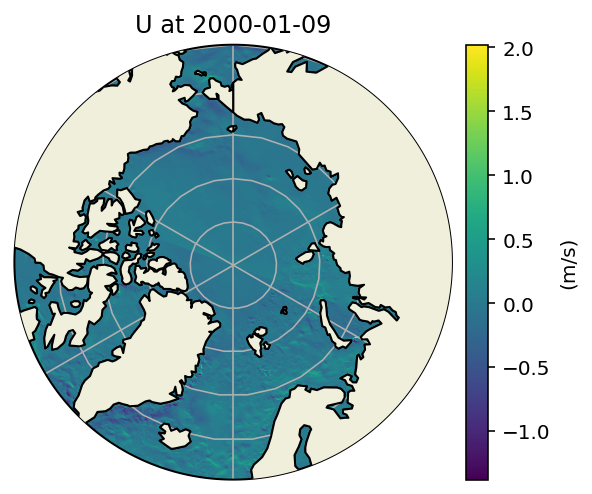

In [11]:
plot.from_field(fieldset.U, latRange=(60,90), polar=True)

In [11]:
lons = [23. for i in range(10)]
lats = [73. for i in range(10)]
times= [np.datetime64('2000-01-10') + np.timedelta64(i*7, 'D') for i in range(10)]
pset = ParticleSet.from_list(fieldset,
                             JITParticle,
                             lon = lons,
                             lat = lats,
                             time = times)
kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(kernelCollection.wrapLon)
pfile = pset.ParticleFile(name = 'test_timestamps.nc', outputdt=delta(days=1))
pset.execute(kernels,
             runtime = delta(days=70),
             dt = delta(minutes=60),
             output_file = pfile,
             recovery = {ErrorCode.ErrorOutOfBounds: kernelCollection.deleteParticle})

INFO: Compiled JITParticleAdvectionRK4wrapLon ==> /tmp/parcels-23300/bfef9b676c1048e9fd255f34aba61925_0.so
INFO: Temporary output files are stored in out-LJDIBBLX.
INFO: You can use "parcels_convert_npydir_to_netcdf out-LJDIBBLX" to convert these to a NetCDF file during the run.
N/A% (0 of 6048000.0) |                  | Elapsed Time: 0:00:00 ETA:  --:--:--
 72% (4406400.0 of 6048000.0) |#######   | Elapsed Time: 0:00:00 ETA:   0:00:00
 74% (4492800.0 of 6048000.0) |#######   | Elapsed Time: 0:00:00 ETA:   0:00:00
 75% (4579200.0 of 6048000.0) |#######   | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (4665600.0 of 6048000.0) |#######   | Elapsed Time: 0:00:00 ETA:   0:00:00
 78% (4752000.0 of 6048000.0) |#######   | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (4838400.0 of 6048000.0) |########  | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (4924800.0 of 6048000.0) |########  | Elapsed Time: 0:00:01 ETA:   0:00:00
 82% (5011200.0 of 6048000.0) |########  | Elapsed Time: 0:00:01 ETA:   0:00:00


In [22]:
plotTrajectoriesFile('test_timestamps.nc', mode='movie2d_notebook')

/home/students/4302001/sources/parcels/parcels/scripts/plottrajectoriesfile.py:92: UserWarning: Attempting to set identical left == right == 73.0 results in singular transformations; automatically expanding.
  ax.set_xlim(np.nanmin(lon), np.nanmax(lon))
/home/students/4302001/sources/parcels/parcels/scripts/plottrajectoriesfile.py:93: UserWarning: Attempting to set identical bottom == top == 23.0 results in singular transformations; automatically expanding.
  ax.set_ylim(np.nanmin(lat), np.nanmax(lat))


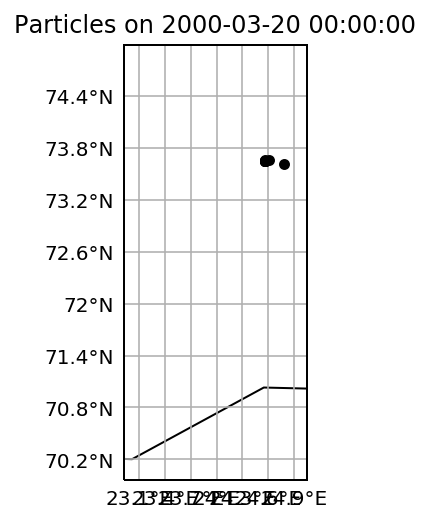

In [17]:
pset.show(domain=(75, 70, 25,23))